<a href="https://colab.research.google.com/github/VictorNiaussat/DeepLearningAction/blob/main/Transformer_Lab_exo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this lab is to implement a transformer rchitecture. The first exercice is a dreict implementation of the paper 'Attention is all you need' proposed in NIPS 2017 by Google Brain for traduction, this implementation is inspired from F. O--. imlementation. Exercice 2 investigates a computer visio application based on a transformer architecture.

Exercice 1

The core of the transformer architecture is the multi-head attention.

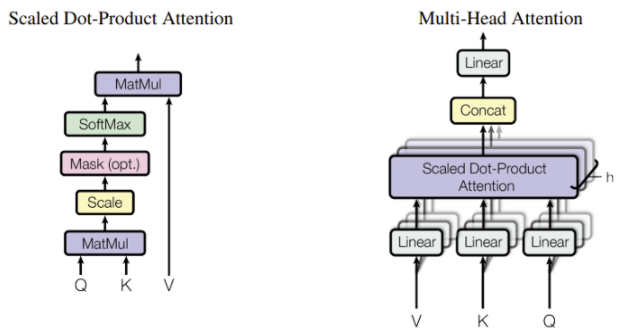



Provide the code for scaled-dot product, note that MatMul operations are translated to torch.bmm in PyTorch. That’s because Q, K, and V (query, key, and value arrays) are batches of matrices, each with shape (batch_size, sequence_length, num_features). Batch matrix multiplication is only performed over the last two dimensions.

In [ ]:
from torch import Tensor
import torch.nn.functional as f


def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    # your code here -- 
    # your code here -- 
    return # your code here --

As illustrated in the previous figure, multi-head attention is composed of identical attention heads. Each attention head contains 3 linear layers, followed by scaled dot-product attention. Encapsulate this in an AttentionHead layer.

In [ ]:
import torch
from torch import nn


class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = # insert your code here 
        self.v = # insert your code here 

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_q, dim_k) for _ in range(num_heads)]
        )
        self.linear = # insert your code here (see the figure)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        #return  insert your code here  (concacatenate) -- 
       # )

The next step is to encode the positional information, Vaswani et. al. (Attention is all you need 2017) encode positional information using trigonometric functions, according to the equation:
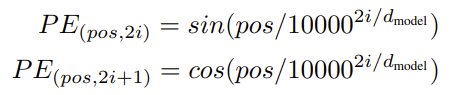



In [ ]:
def position_encoding(
    seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),
) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim // dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

We recall the transformer architecture in the figure below. 

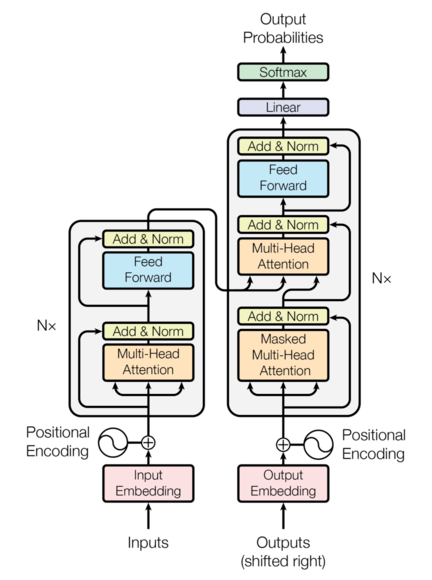


The transformer uses an encoder-decoder architecture. The encoder (left) processes the input sequence and returns a feature vector (or memory vector). The decoder processes the target sequence, and incorporates information from the encoder memory. The output from the decoder is the model’s prediction.
First we need some informations, that are not included in the figure. For example, how should we choose to build the feed forward networks? This is described in the paper '***Each of the layers in our encoder and decoder contains a fully connected feed-forward network, which … consists of two linear transformations with a ReLU activation in between. The dimensionality of input and output is 512, and the inner-layer has dimensionality 2048.***'
Provide the implementation of the **Feed Forward** module.

In [ ]:
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048) -> nn.Module:
    return nn.Sequential(
         # insert your code here  
         # insert your code here (see the figure) -- 
         # insert your code here (see the figure) -- 
    )

As described in the paper, '*The output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. … We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.*'

Complete the missing code to get a module that encapsulate all this. 

In [ ]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "query" tensor is given first, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return # insert your code here  -- 

Using the previous methods, we will create the encoder, provide the missing code

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention = # insert your code here  -- 
            dimension=# insert your code here  
            dropout=dropout,
        )
        self.feed_forward = # insert your code here  -- 
            dimension= # insert your code here  -- 
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src

The decoder module is extremely similar. Just a few small differences:
-The decoder accepts two arguments (target and memory), rather than one.

-There are two multi-head attention modules per layer, instead of one.

-The second multi-head attention accepts memory for two of its inputs.

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  --
    ):
        super().__init__()
        dim_q = dim_k = # insert your code here  
        self.attention_1 = # insert your code here  -
            # insert your code here  
            dimension=# insert your code here  
            dropout=dropout,
        )
        self.attention_2 = # insert your code here  -
            # insert your code here  -
            dimension=# insert your code here  --
            dropout=dropout,
        )
        self.feed_forward = # insert your code here  --
            # insert your code here  --
            dimension=# insert your code here  --
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = # insert your code here  -- 
        tgt = # insert your code here  -- 
        return # insert your code here  -- 


class TransformerDecoder(nn.Module):
    def __init__(
        self,
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  -- 
        # insert your code here  -- 
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
               # insert your code here  -- 
                for _ in range(num_layers)
            ]
        )
        self.linear = # insert your code here  --

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = # insert your code here  -- 
        tgt += # insert your code here  --
        for layer in self.layers:
            # insert your code here  --

        return # insert your code here  --

The final step is to build a Trasformer class: put an encoder and decoder together, and pass data through them in the correct order.

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
        )
        self.decoder = # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
            # insert your code here  --
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return # insert your code here  --

Create a simple test, construct random tensors for src and tgt, check that the model executes without errors, and confirm that the output tensor has the correct shape.

In [ ]:
src = torch.rand(64, 32, 512)
tgt = torch.rand(64, 16, 512)
out = Transformer()(src, tgt)
print(out.shape)
# torch.Size([64, 16, 512])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


torch.Size([64, 16, 512])
